## Classifying cells

Here I develop my idea of a very simple nearest-neighbor classifier to find cells of a type

In [56]:
import numpy as np
import scipy as sp
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn
import itertools as it
import h5py
exec( open( "log_progress.py" ).read() )

%load_ext cython

First, load the AnnData object with UMI counts and metadata

In [2]:
cnts = sc.read_h5ad( "Tabula_muris_10x.h5ad" )
cnts

AnnData object with n_obs × n_vars = 55656 × 23433 
    obs: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

The counts are given in a compressed sparse row (CSR) matrix:

In [3]:
cnts.X.__class__

scipy.sparse.csr.csr_matrix

This is good to quickly get expression vectors for cells but not to get expression of one gene for all cells, as we need next. Luckily, Scanpy allows to simply transpose the whole thing:

In [4]:
cntsT = cnts.transpose()
cntsT

AnnData object with n_obs × n_vars = 23433 × 55656 
    var: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

My test case will be endothelial cells (inner lining of blood vessels). These cells appear in most of the tissues, which makes them interesting. In the Tabula muris tissue supplement, they used different markers depending on tissue, but nearly always included Pecam1 (a.k.a. CD31), a protein found on the surface of endothelial cells as well as various blood cells and for Cadherin-5 (Cdh5, CD144). I am not quite sure yet whether these two markers are together sufficiently specific to catch only endothelial cells, but for now I will assume so. 

I select cells with more than minimal expression of the two markers, and call these my "gold-standard" endothelial cells.

In [5]:
cnts.obs["endo_gold"] = ( cntsT["Pecam1",:].X > 3 ) & ( cntsT["Cdh5",:].X > 3 )

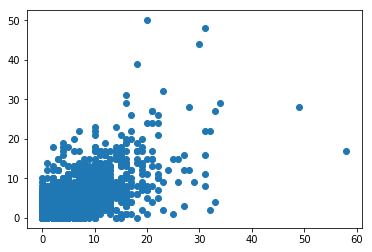

In [6]:
plt.scatter( cntsT["Pecam1",:].X, cntsT["Cdh5",:].X )

I check what cell types the Tabula muris authors have assigned in their Seurat-based analysis to the cells that I have just picked as "gold" endothelial cells.

In [7]:
cnts[ cnts.obs.endo_gold, : ].obs.cell_ontology_class.value_counts()

endothelial cell                        612
lung endothelial cell                   193
kidney capillary endothelial cell        72
endocardial cell                         29
macrophage                                2
stromal cell                              1
myeloid cell                              1
mesenchymal stem cell                     1
leukocyte                                 1
endothelial cell of hepatic sinusoid      1
Name: cell_ontology_class, dtype: int64

This seems to have worked quite well so far. (Note that the endocardium is simply the endothelium of the heart, i.e., these are endothelial cells, too.) Only 6 false positives in 915 cells. And maybe these aren't false, either, but were wrongly classified in the Seurat analysis.

However, we have probably missed many endothelial cells where the sequencing has failed to detect the two marker genes. The idea is now that we can probably still recognize them as being intermixed between the gold endothelial cells.

Hence, I open the similarity score matrix file, that I have created in 

In [8]:
h5f = h5py.File( "sims.hdf5", "r" )
h5sim = h5f["sim_matrix"]

As a preparation, I find for each cell its *k*=20 nearest neighbors, storing this in an array `nn`. This can be done quickly, in less than a minute, thanks to numpy's `argpartition` function, which allows me to bring the *k* smallest distances to the front and then sort only them.

Afterwars `nn[i,j]` contains the index (row number in `cnts.X`) of the $(j+1)$-th nearest neighbor of the cell with index $i$, i.e., column 0 contains the nearest, column 1 the next-to-nearest neighbors etc.

In [9]:
k = 20
nn = np.empty( ( cnts.n_obs, k ), 'i' )
for i in log_progress( range(cnts.n_obs) ):
    a = -h5sim[ i, : ]
    argpart = a.argpartition(k+1)[:(k+1)]
    nn[i,:] = argpart[ a[argpart].argsort() ][1:]


I use this now to count for each cell how many of its 10 nearest neighbors are among the "gold endothelial" cells.

In [10]:
a = np.full( (cnts.n_obs,), -1 )
for i in log_progress( range(cnts.n_obs) ):
    a[i] = cnts.obs.endo_gold[ nn[i,:10] ].sum()
cnts.obs["n_endo_gold_nghbrs"] = a        

Let's make a histogram of these values, with stacked bars splitting by cells that are themselves endo-gold (orange) and the others (blue).

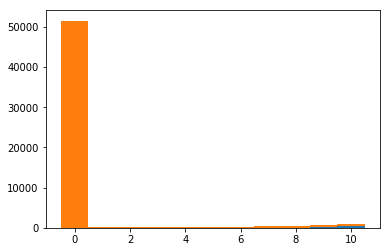

In [11]:
plt.hist( 
    [ cnts[  cnts.obs.endo_gold ].obs.n_endo_gold_nghbrs, 
      cnts[ ~cnts.obs.endo_gold ].obs.n_endo_gold_nghbrs  ],
    stacked=True, bins=np.arange(-.5,11.5) );

Blow up the y axis.

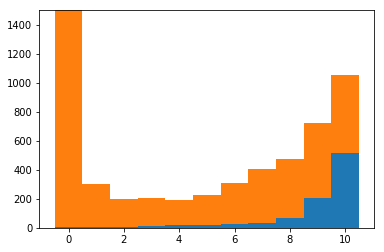

In [12]:
plt.hist( 
    [ cnts[  cnts.obs.endo_gold, : ].obs.n_endo_gold_nghbrs, 
      cnts[ ~cnts.obs.endo_gold, : ].obs.n_endo_gold_nghbrs  ],
    stacked=True, bins=np.arange(-.5,11.5) );
plt.ylim(0,1500);

Let's define "endo gold-negative cells" as those which neither express any markers of the two nor have any endo golds among their 10 nearest neighbors.

In [13]:
cnts.obs["endo_gold_neg"] = ( cntsT["Pecam1",:].X == 0 ) & ( cntsT["Cdh5",:].X == 0 ) & \
  ( cnts.obs.n_endo_gold_nghbrs == 0 )

cnts.obs.endo_gold_neg.sum()

46574

Get the expression values via square root and L2-nomalization, as used in the distance calculation.

In [14]:
exprs = cnts.copy()
exprs.X = sp.sparse.vstack( np.sqrt( cnts.X[i,:] ) / np.sqrt( cnts.X[i,:].sum() ) 
             for i in log_progress( range(cnts.n_obs) ) )

Here is utility function that takes the row number or index label of an observation ("cell") in an AnnData object and returns a Pandas Series vector with the expression values of this cell for all all genes.

In [15]:
def get_dense_obs( anndata, obs ):
    ans = pd.Series( 0, anndata.var.index, name = obs)
    if not isinstance( obs, int ):
        obs = anndata.obs.index.get_loc( obs )
    indptr_from = anndata.X.indptr[ obs ]
    indptr_to   = anndata.X.indptr[ obs+1 ]
    ans[ anndata.X.indices[ indptr_from : indptr_to ] ] = \
       anndata.X.data[ indptr_from : indptr_to ] 
    return ans

Get means and SDs of the endo gold-positive and gold-negative cells. (This is very slow; I should look up how to calculate SDs directly on sparse data.)

In [16]:
exprsT = exprs.transpose()

In [17]:
endo_params = pd.DataFrame( index = exprs.var.index, dtype="f",
        columns = [ "pos_mean", "pos_sd", "neg_mean", "neg_sd" ] )

for i in log_progress( exprs.var.index ):
    x = get_dense_obs( exprsT, i )
    endo_params.pos_mean[i] = np.mean( x[ exprs.obs.endo_gold ] )
    endo_params.pos_sd  [i] = np.std ( x[ exprs.obs.endo_gold ] )
    endo_params.neg_mean[i] = np.mean( x[ exprs.obs.endo_gold_neg ] )
    endo_params.neg_sd  [i] = np.std ( x[ exprs.obs.endo_gold_neg ] )
    
endo_params

,pos_mean,pos_sd,neg_mean,neg_sd
index,,,,
Xkr4,0.000000,0.000000,6.391235e-06,0.000259
Rp1,0.000010,0.000297,9.353284e-06,0.000352
Sox17,0.012669,0.014307,4.312611e-05,0.000789
Mrpl15,0.003787,0.006421,3.856614e-03,0.006474
Lypla1,0.004072,0.006510,3.628493e-03,0.006425
Tcea1,0.006367,0.007519,5.311561e-03,0.007339
Rgs20,0.000009,0.000274,5.946376e-05,0.000704
Atp6v1h,0.002595,0.005189,1.829227e-03,0.004630
Oprk1,0.000011,0.000339,2.259150e-06,0.000138


Get separation scores

In [21]:
endo_params["sep_score"] = ( endo_params.pos_mean - endo_params.neg_mean ) / ( endo_params.pos_sd + endo_params.neg_sd )

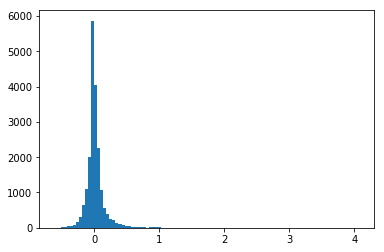

In [22]:
x =  np.asarray( endo_params.sep_score, dtype="f" )
plt.hist( x[ ~np.isnan(x) ], 100 );

In [23]:
endo_params[ np.abs( endo_params.sep_score ) > .5 ].sort_values("sep_score")

,pos_mean,pos_sd,neg_mean,neg_sd,sep_score
index,,,,,
Rpsa,0.029553,0.011716,0.048299,0.018967,-0.610964
Rpl10a,0.028262,0.011648,0.045402,0.018680,-0.565130
Rps3a,0.041556,0.012336,0.060441,0.021120,-0.564472
Rpl12,0.024935,0.012059,0.042536,0.019946,-0.549959
Sdc4,0.002296,0.005817,0.016341,0.019884,-0.546472
Rplp0,0.045371,0.015702,0.069174,0.028819,-0.534625
Ly6d,0.001013,0.003552,0.017355,0.027103,-0.533068
Rpl11,0.037909,0.010587,0.052865,0.017634,-0.529976
Rpl13a,0.051367,0.014225,0.072957,0.026838,-0.525787


In [41]:
endo_goodgenes = ( endo_params.isna() ).sum(axis=1) == 0
endo_params.pos_sd = np.maximum( endo_params.pos_sd, .0003 )
endo_params.neg_sd = np.maximum( endo_params.neg_sd, .0003 )

In [91]:
endo_params.pos_mean.values

array([0.0000000e+00, 9.8222235e-06, 1.2668809e-02, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [136]:
%%cython --annotate
import numpy as np
cimport numpy as np

def naivebayes( exprs, endo_params, endo_goodgenes ):

    cdef int i, j, ind_from, ind_to, ip
    cdef int n_var = exprs.n_vars
    
    cdef np.float_t lbf, ap, an
    
    cdef int[:] indptr = exprs.X.indptr
    cdef int[:] indices = exprs.X.indices
    cdef np.float_t[:] data = exprs.X.data

    cdef float[:] pos_mean = endo_params.pos_mean.values
    cdef float[:] pos_sd   = endo_params.pos_sd.values
    cdef float[:] neg_mean = endo_params.neg_mean.values
    cdef float[:] neg_sd   = endo_params.neg_sd.values
    
    ans_np = np.zeros( (exprs.n_obs,) )
    cdef np.float_t[:] ans = ans_np
    

    for i in range(exprs.n_obs):

        ind_from  = indptr[i]
        ind_to    = indptr[i+1]
        ip = ind_from
        lbf = 0
        
        for j in range( n_var ):
            
            ap = pos_mean[j]
            an = neg_mean[j]
            if ip < ind_to and indices[ip] == j:
                ap -= data[ip]
                an -= data[ip]
                ip += 1
            ap /= pos_sd[j]
            an /= neg_sd[j]
            lbf += ( ap * ap - an * an ) / (-2)
        
        ans[i] = lbf    
        
        if i % 1000 == 0:
            print(i // 1000, end=" ")

    return ans_np

In [137]:
%time a = naivebayes( exprs, endo_params, endo_goodgenes )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 CPU times: user 8 s, sys: 4.93 ms, total: 8.01 s
Wall time: 8 s


In [132]:
a2 = np.zeros( (exprs.n_obs,) )
for i in log_progress( range(1000) ):
    #x = np.asarray( exprs.X[i, : ].todense() ).flatten()[ endo_goodgenes ]
    x = get_dense_obs( exprs, i )[ endo_goodgenes ]
    a2[i] = \
       sp.stats.norm.logpdf( np.array( ( x - endo_paramsB.pos_mean ) / endo_paramsB.pos_sd, dtype="f" ) ).sum() - \
       sp.stats.norm.logpdf( np.array( ( x - endo_paramsB.neg_mean ) / endo_paramsB.neg_sd, dtype="f" ) ).sum() 

In [135]:
-a/2

array([-24846.53941453, -24567.79170064, -21525.58481013, ...,
        26057.93882709,  -5560.60134052, -34102.35052317])

In [134]:
a2

array([-24846.5389222 , -24567.79188812, -21525.5849619 , ...,
            0.        ,      0.        ,      0.        ])

In [171]:
np.log( exprs.obs.endo_gold.sum() ) - np.log( exprs.obs.endo_gold_neg.sum() ) 

-3.9298736592176606

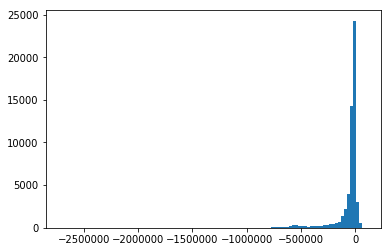

In [290]:
plt.hist(a,100);

(-100000, 100000)

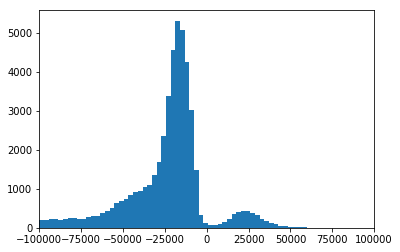

In [274]:
plt.hist( a, 1000 ); plt.xlim( -100000,100000);

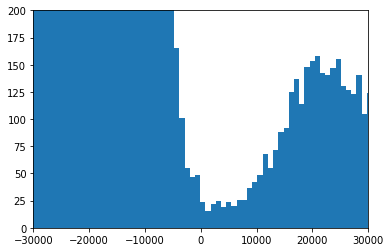

In [295]:
plt.hist( a, 3000 ); plt.xlim( -30000, 30000); plt.ylim( 0, 200 );

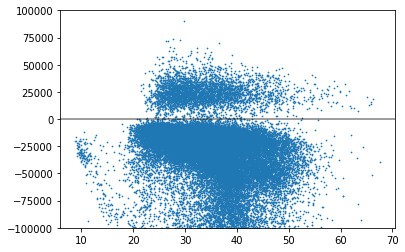

In [286]:
plt.scatter( np.asarray(exprs.X.sum(axis=1)).flatten(), a, s=.5 )
plt.ylim( -100000,100000)
plt.axhline( 0, 0, 1, color="black", alpha=.5 )

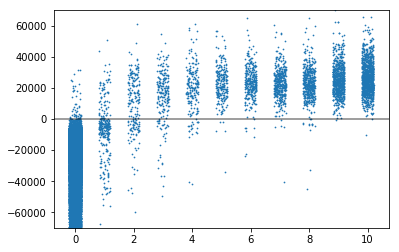

In [299]:
plt.scatter( exprs.obs.n_endo_gold_nghbrs + np.random.uniform( -.2, .2, exprs.n_obs) , a, s=.5 )
plt.ylim( -70000, 70000 )
plt.axhline( 0, 0, 1, color="black", alpha=.5 )

In [314]:
pd.crosstab( exprs.obs.cell_ontology_class, [ a > 0, a > 3000 ] ).sort_values( ( True, True ), ascending=False )

col_0                                              False True       
col_1                                              False False True 
cell_ontology_class                                                 
endothelial cell                                      67    21  2755
lung endothelial cell                                  7     3   452
kidney capillary endothelial cell                      7     2   383
endocardial cell                                       0     0    63
stromal cell                                        3224     8     8
leukocyte                                            243     3     5
kidney collecting duct epithelial cell               439     0     4
endothelial cell of hepatic sinusoid                  24     1     3
mesangial cell                                        48     0     3
neuroendocrine cell                                  353     7     2
mesenchymal stem cell                               1130     4     2
macrophage                                          1317     1     2
T cell                                              4406     2     1
B cell                                              8291     2     1
mesenchymal cell                                    7848     0     0
keratinocyte                                        3076     0     0
mast cell                                             24     0     0
monocyte                                             525     0     0
non-classical monocyte                               219     1     0
natural killer cell                                 1096     0     0
professional antigen presenting cell                  31     0     0
promonocyte                                          257     0     0
luminal epithelial cell of mammary gland             459     0     0
myeloid cell                                          87     0     0
late pro-B cell                                      265     0     0
kidney proximal straight tubule epithelial cell     1198     0     0
kidney loop of Henle ascending limb epithelial ...   471     0     0
skeletal muscle satellite cell                       354     0     0
kidney cell                                           45     0     0
proerythroblast                                      265     0     0
hepatocyte                                          1764     0     0
immature T cell                                     1354     0     0
immature B cell                                      113     0     0
Fraction A pre-pro B cell                             66     0     0
Langerhans cell                                       38     0     0
alveolar macrophage                                  345     0     0
basal cell                                           392     0     0
basal cell of epidermis                             4424     0     0
basophil                                              61     0     0
bladder cell                                        1203     0     0
bladder urothelial cell                             1167     0     0
blood cell                                          1139     0     0
cardiac muscle cell                                   60     0     0
ciliated columnar cell of tracheobronchial tree       49     0     0
classical monocyte                                   161     0     0
dendritic cell                                        42     0     0
duct epithelial cell                                  27     0     0
early pro-B cell                                      65     0     0
epithelial cell                                      892     0     0
erythroblast                                         155     0     0
erythrocyte                                           81     0     0
fibroblast                                           226     0     0
granulocyte                                          725     0     0
granulocytopoietic cell                              378     0     0
hematopoietic precursor cell                         392     0     

-------

Playing with sparse matrices

-------

From here on junk:

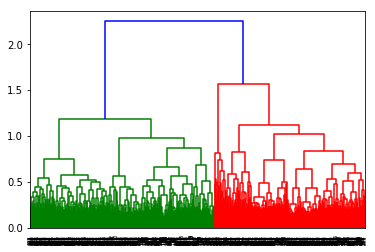

In [29]:
a = h5sim[ cnts.obs.endo_gold, : ][ : , cnts.obs.endo_gold ]
cl = sp.cluster.hierarchy.complete( np.sqrt( 1 - a/2 ) ) 
sp.cluster.hierarchy.dendrogram( cl );

In [72]:
pd.crosstab( 
    cnts.obs.cell_ontology_class[ cnts.obs.endo_gold ], 
    sp.cluster.hierarchy.cut_tree( cl, 2 ).transpose()[0], dropna=False )

col_0,0,1
cell_ontology_class,,
B cell,0,0
DN1 thymic pro-T cell,0,0
Fraction A pre-pro B cell,0,0
Langerhans cell,0,0
T cell,0,0
alveolar macrophage,0,0
basal cell,0,0
basal cell of epidermis,0,0
basophil,0,0


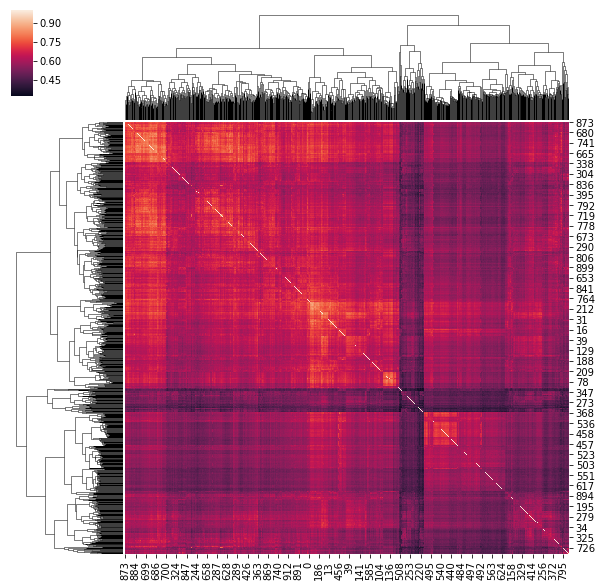

In [25]:
seaborn.clustermap( h5sim[ cnts.obs.endo_gold, : ][ : , cnts.obs.endo_gold ] );